# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

# Data & Visualization
### Note: brighter the area, farther it is in the image, brighter => more depth
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>


In [ ]:
train_csv = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train')
base_path = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data')

In [ ]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

,0,1
0,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
1,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
2,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
3,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
4,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...


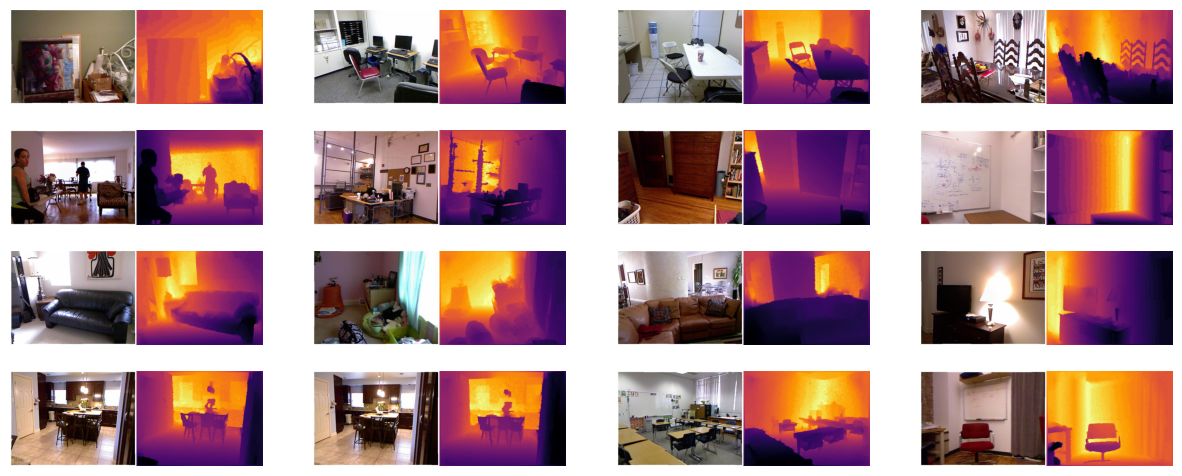

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [ ]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import torch.nn as nn

model_name = "LiheYoung/depth-anything-small-hf"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForDepthEstimation.from_pretrained(model_name).to(device)


Using device: cuda


c:\Users\Torenia\.conda\envs\DepthAnythingTriangulation\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Dataset and Overlay
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [ ]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [ ]:
import random

class MaskOverlayDepthDataset(Dataset):
    def __init__(self, df, mask_path, apply_prob=1.0, crop_type='center'):
        """
        crop_type:
            'center' → center crop to 518x518
            'random' → random crop to 518x518
            None     → no cropping (keep resized full image)
        """
        self.df = df.reset_index(drop=True)
        self.mask = Image.open(mask_path).convert("L")  # grayscale mask
        self.apply_prob = apply_prob
        self.crop_type = crop_type

    def __len__(self):
        return len(self.df)

    def resize_keep_aspect(self, img, target_short=518):
        w, h = img.size
        if w < h:
            new_w = target_short
            new_h = int(h * (target_short / w))
        else:
            new_h = target_short
            new_w = int(w * (target_short / h))
        return img.resize((new_w, new_h), Image.BILINEAR)

    def get_crop_coords(self, w, h):
        """Get crop coordinates for consistent cropping."""
        left = (w - 518) // 2
        top = (h - 518) // 2
        if self.crop_type == 'random':
            left = random.randint(0, max(0, w - 518))
            top = random.randint(0, max(0, h - 518))
        return (left, top, left + 518, top + 518)

    def __getitem__(self, idx):
        rgb_path = self.df.iloc[idx, 0]
        depth_path = self.df.iloc[idx, 1]

        # Load images
        rgb = Image.open(rgb_path).convert("RGB")
        depth = Image.open(depth_path).convert("L")

        # Resize keeping aspect ratio (same target)
        rgb = self.resize_keep_aspect(rgb)
        depth = self.resize_keep_aspect(depth)

        # --- Make mask same size as rgb ---
        mask = self.mask.resize(rgb.size, Image.BILINEAR)

        # --- Apply cropping if enabled ---
        if self.crop_type in ['center', 'random']:
            crop_box = self.get_crop_coords(*rgb.size)
            rgb = rgb.crop(crop_box)
            depth = depth.crop(crop_box)
            mask = mask.crop(crop_box)

        # --- Convert to arrays ---
        rgb_arr = np.array(rgb).astype(np.float32)
        depth_arr = np.array(depth).astype(np.float32)
        mask_arr = np.array(mask).astype(np.float32) / 255.0

        # --- Optional masking ---
        if random.random() < self.apply_prob:
            rgb_arr = rgb_arr * mask_arr[..., None]
            max_depth = depth_arr.max()
            depth_arr = np.where(mask_arr > 0, depth_arr, max_depth)

        # --- Convert to tensors ---
        rgb_tensor = torch.from_numpy(rgb_arr / 255.0).permute(2, 0, 1)
        depth_tensor = torch.from_numpy(depth_arr).unsqueeze(0)

        return rgb_tensor, depth_tensor


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

mask_path = "C:/Users/Torenia/OneDrive/Documents/GitHub/JAIST/Depth Anything Triangulation/Code/Undistort-and-Depth/MaskTrain.png"

df_train, df_test = train_test_split(df, test_size=0.05, shuffle=True)

df_train = df_train.sample(n=100, random_state=42) #reduce for faster testing

df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=True)

train_ds = MaskOverlayDepthDataset(df_train, mask_path, apply_prob=1.0, crop_type='center')
val_ds = MaskOverlayDepthDataset(df_val, mask_path, apply_prob=1.0, crop_type=None)
test_ds = MaskOverlayDepthDataset(df_test, mask_path, apply_prob=1.0, crop_type=None)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=True)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Train: 90 Val: 10 Test: 2535


# Transforms Visualization
<div style="width:100%;height:0;border-bottom: 3px solid #DEF839;margin-bottom: 1rem;"></div>

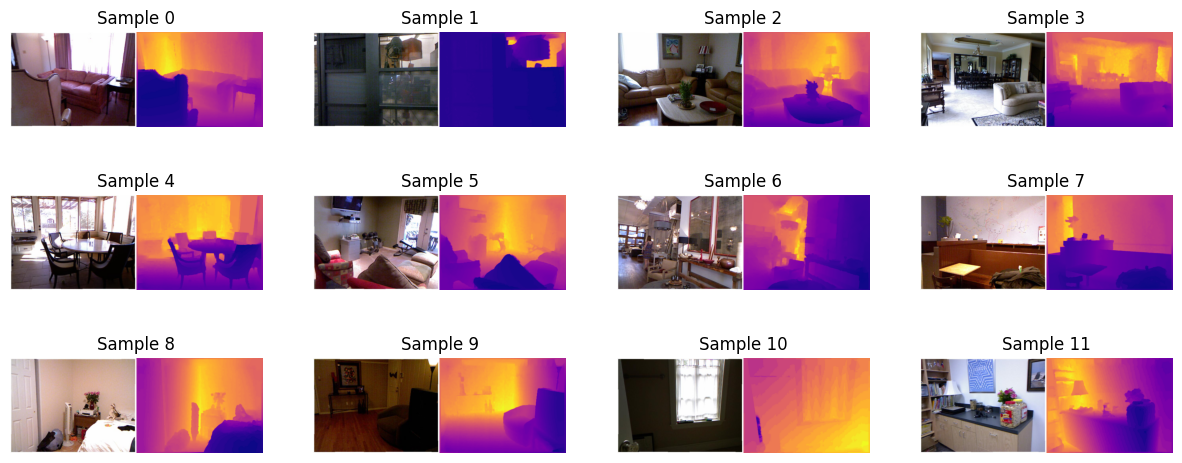

In [ ]:
plt.figure(figsize=(15, 6))

for i in range(12):
    # --- Load masked sample from dataset ---
    x, y = test_ds[i]

    # RGB: [C,H,W] -> [H,W,3] uint8
    rgb_masked = (x.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # Depth: [1,H,W] -> [H,W]
    depth_masked = y.squeeze().cpu().numpy()

    # --- Normalize and colorize depth ---
    depth_min, depth_max = np.nanmin(depth_masked), np.nanmax(depth_masked)
    if depth_max - depth_min < 1e-8:
        depth_norm = np.zeros_like(depth_masked, dtype=np.uint8)
    else:
        depth_norm = cv2.normalize(depth_masked, None, 0, 255, cv2.NORM_MINMAX)
        depth_norm = np.clip(depth_norm, 0, 255).astype(np.uint8)

    depth_color = cv2.applyColorMap(depth_norm, cv2.COLORMAP_PLASMA)[..., ::-1]  # BGR→RGB

    # --- Match size to RGB just in case ---
    H, W = rgb_masked.shape[:2]
    depth_color_resized = cv2.resize(depth_color, (W, H), interpolation=cv2.INTER_NEAREST)

    # --- Concatenate side by side ---
    # Ensure both are 3D arrays (H, W, 3)
    if depth_color_resized.ndim == 2:
        depth_color_resized = cv2.cvtColor(depth_color_resized, cv2.COLOR_GRAY2RGB)

    row = np.concatenate([rgb_masked, depth_color_resized], axis=1)  # side-by-side

    # --- Display ---
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(row.astype("uint8"))
    plt.axis("off")
    plt.title(f"Sample {i}")

# Training
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>

In [ ]:
# # --- Required imports (if not already present) ---
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import math
# import numpy as np
# from tqdm.auto import tqdm

# # --- Helper: affine-invariant loss (MiDaS-style) ---
# def affine_invariant_loss(pred, gt, eps=1e-6):
#     """
#     pred, gt: tensors with shape [B, 1, H, W] or [B, H, W]
#     Returns mean L1 of (aligned pred, aligned gt) per-sample.
#     Implementation follows MiDaS/Depth Anything description:
#        - compute per-sample translation t = median(d)
#        - compute per-sample scale s = mean(|d - t|)
#        - align and compute L1
#     """
#     if pred.dim() == 4:
#         # B,1,H,W -> B, H, W
#         pred = pred.squeeze(1)
#     if gt.dim() == 4:
#         gt = gt.squeeze(1)

#     B = pred.shape[0]
#     losses = []
#     for i in range(B):
#         p = pred[i]
#         g = gt[i]

#         # Flatten valid pixels (ignore NaNs / infs)
#         valid_mask = torch.isfinite(g)
#         if valid_mask.sum() == 0:
#             losses.append(torch.tensor(0.0, device=pred.device))
#             continue

#         p_v = p[valid_mask]
#         g_v = g[valid_mask]

#         # Median translation
#         t_p = p_v.median()
#         t_g = g_v.median()

#         p_hat = p_v - t_p
#         g_hat = g_v - t_g

#         # scale s is mean absolute deviation (paper uses 1/(HW) sum |d - t|)
#         s_p = torch.mean(torch.abs(p_hat)) + eps
#         s_g = torch.mean(torch.abs(g_hat)) + eps

#         p_hat = p_hat / s_p
#         g_hat = g_hat / s_g

#         losses.append(torch.mean(torch.abs(p_hat - g_hat)))

#     return torch.stack(losses).mean()


# # --- Convert metric depth -> disparity (safe) ---
# def depth_to_disparity(depth, min_clip=1e-3):
#     """depth: torch tensor [...], depth in meters (or arbitrary). Returns disparity 1/depth."""
#     d = depth.clone().float()
#     # avoid division by zero
#     d = torch.clamp(d, min=min_clip)
#     return 1.0 / d


# # --- Build optimizer with encoder/decoder groups ---
# def make_optimizer(model, base_encoder_lr=5e-6, decoder_lr_mult=10.0, weight_decay=1e-2):
#     # The HF AutoModelForDepthEstimation typically exposes `model.base_model` or `model.encoder` for encoder.
#     # We'll put any parameters that *already* have pretrained weights into encoder group heuristically by name.
#     encoder_params = []
#     decoder_params = []
#     for name, p in model.named_parameters():
#         if not p.requires_grad:
#             continue
#         # Heuristic: encoder contains "encoder", "vit", "backbone", or "base_model"
#         if ("encoder" in name) or ("vit" in name) or ("base_model" in name) or ("backbone" in name):
#             encoder_params.append(p)
#         else:
#             decoder_params.append(p)

#     param_groups = []
#     if encoder_params:
#         param_groups.append({"params": encoder_params, "lr": base_encoder_lr})
#     if decoder_params:
#         param_groups.append({"params": decoder_params, "lr": base_encoder_lr * decoder_lr_mult})

#     optimizer = optim.AdamW(param_groups, weight_decay=weight_decay)
#     return optimizer

# # --- Training loop ---
# def train_one_epoch(model, processor, dataloader, device,
#                     optimizer,
#                     epoch,
#                     scaler=None,
#                     max_grad_norm=None):
#     model.train()
#     running_loss = 0.0
#     pbar = tqdm(dataloader, desc=f"Train E{epoch}")
#     for batch in pbar:
#         x, y = batch   # x: [B,3,H,W] float in 0..1, y: [B,1,H_r,W_r] (raw depth)
#         x = x.to(device)
#         y = y.to(device)

#         # Prepare inputs for HF model (model expects pixel_values normalized via processor)
#         # processor accepts numpy images or PIL; to be safe convert to CPU numpy here
#         imgs_np = (x.permute(0,2,3,1).cpu().numpy() * 255.0).astype(np.uint8)
#         inputs = processor(images=list(imgs_np), return_tensors="pt").to(device)

#         with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
#             out = model(pixel_values=inputs["pixel_values"]).predicted_depth  # [B, H_out, W_out] or [B,1,H,W]
#             # make sure pred is [B, 1, H_out, W_out]
#             if out.dim() == 3:
#                 pred = out.unsqueeze(1)
#             elif out.dim() == 4:
#                 pred = out
#             else:
#                 raise RuntimeError("unexpected predicted_depth dims: " + str(out.shape))

#             # Interpolate pred to GT size
#             pred = torch.nn.functional.interpolate(pred, size=y.shape[-2:], mode="bilinear", align_corners=False)

#             # Convert GT depth -> disparity (paper does d = 1/t and normalize per-sample)
#             # y may be uint8 or floats 0..255 depending on dataset. Make sure y is in meters or relative units.
#             # If your depth is already disparity/normalized, adapt accordingly. Here we follow paper:
#             gt_disp = depth_to_disparity(y)    # safe 1/depth

#             # Optionally normalize to 0..1 per sample (paper normalizes disparity per-map)
#             # compute per-sample min/max and rescale to [0,1] to match model training behavior
#             B = gt_disp.shape[0]
#             gt_disp_norm = torch.zeros_like(gt_disp)
#             for i in range(B):
#                 g = gt_disp[i]
#                 valid = torch.isfinite(g)
#                 if valid.sum() == 0:
#                     continue
#                 g_v = g[valid]
#                 mn = g_v.min()
#                 mx = g_v.max()
#                 if mx - mn < 1e-8:
#                     gt_disp_norm[i] = g * 0.0
#                 else:
#                     gt_disp_norm[i] = (g - mn) / (mx - mn)

#             # The model predicts some scale; to compare fairly we compute affine-invariant loss
#             loss = affine_invariant_loss(pred, gt_disp_norm)

#         optimizer.zero_grad()
#         loss.backward()
#         if max_grad_norm is not None:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#         optimizer.step()

#         running_loss += loss.item()
#         pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
#     return running_loss / len(dataloader)


# # --- Simple evaluation (compute affine loss on val set) ---
# @torch.no_grad()
# def evaluate(model, processor, dataloader, device):
#     model.eval()
#     total = 0.0
#     count = 0
#     for x, y in dataloader:
#         x = x.to(device)
#         y = y.to(device)
#         imgs_np = (x.permute(0,2,3,1).cpu().numpy() * 255.0).astype(np.uint8)
#         inputs = processor(images=list(imgs_np), return_tensors="pt").to(device)
#         out = model(pixel_values=inputs["pixel_values"]).predicted_depth
#         if out.dim() == 3:
#             pred = out.unsqueeze(1)
#         else:
#             pred = out
#         pred = torch.nn.functional.interpolate(pred, size=y.shape[-2:], mode="bilinear", align_corners=False)
#         gt_disp = depth_to_disparity(y)
#         # normalize per-sample
#         B = gt_disp.shape[0]
#         gt_disp_norm = torch.zeros_like(gt_disp)
#         for i in range(B):
#             g = gt_disp[i]
#             valid = torch.isfinite(g)
#             if valid.sum() == 0:
#                 continue
#             g_v = g[valid]
#             mn = g_v.min()
#             mx = g_v.max()
#             if mx - mn < 1e-8:
#                 gt_disp_norm[i] = g * 0.0
#             else:
#                 gt_disp_norm[i] = (g - mn) / (mx - mn)

#         loss = affine_invariant_loss(pred, gt_disp_norm)
#         total += loss.item()
#         count += 1
#     return total / max(1, count)


# # --- Example: assemble optimizer and run training ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = make_optimizer(model, base_encoder_lr=5e-6, decoder_lr_mult=10.0)
# # optional: scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=1000)
# scaler = None

# n_epochs = 3  # quick test: keep small, real fine-tuning needs more data/epochs
# best_val = 1e9
# for epoch in range(n_epochs):
#     train_loss = train_one_epoch(model, processor, train_loader, device, optimizer, epoch, scaler, max_grad_norm=1.0)
#     val_loss = evaluate(model, processor, val_loader, device)
#     print(f"Epoch {epoch} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")
#     # save checkpoint when val improves
#     if val_loss < best_val:
#         best_val = val_loss
#         model.save_pretrained("./DepthAnything_Masked_Finetuned")
#         processor.save_pretrained("./DepthAnything_Masked_Finetuned")
#         print("Saved best model.")


Train E0:   0%|          | 0/23 [00:00<?, ?it/s]

C:\Users\Torenia\AppData\Local\Temp\ipykernel_37980\2797434200.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 0 train_loss=0.2678 val_loss=0.2882
Saved best model.


Train E1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1 train_loss=0.2986 val_loss=0.3359


Train E2:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2 train_loss=0.2724 val_loss=0.3121


# Testing
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


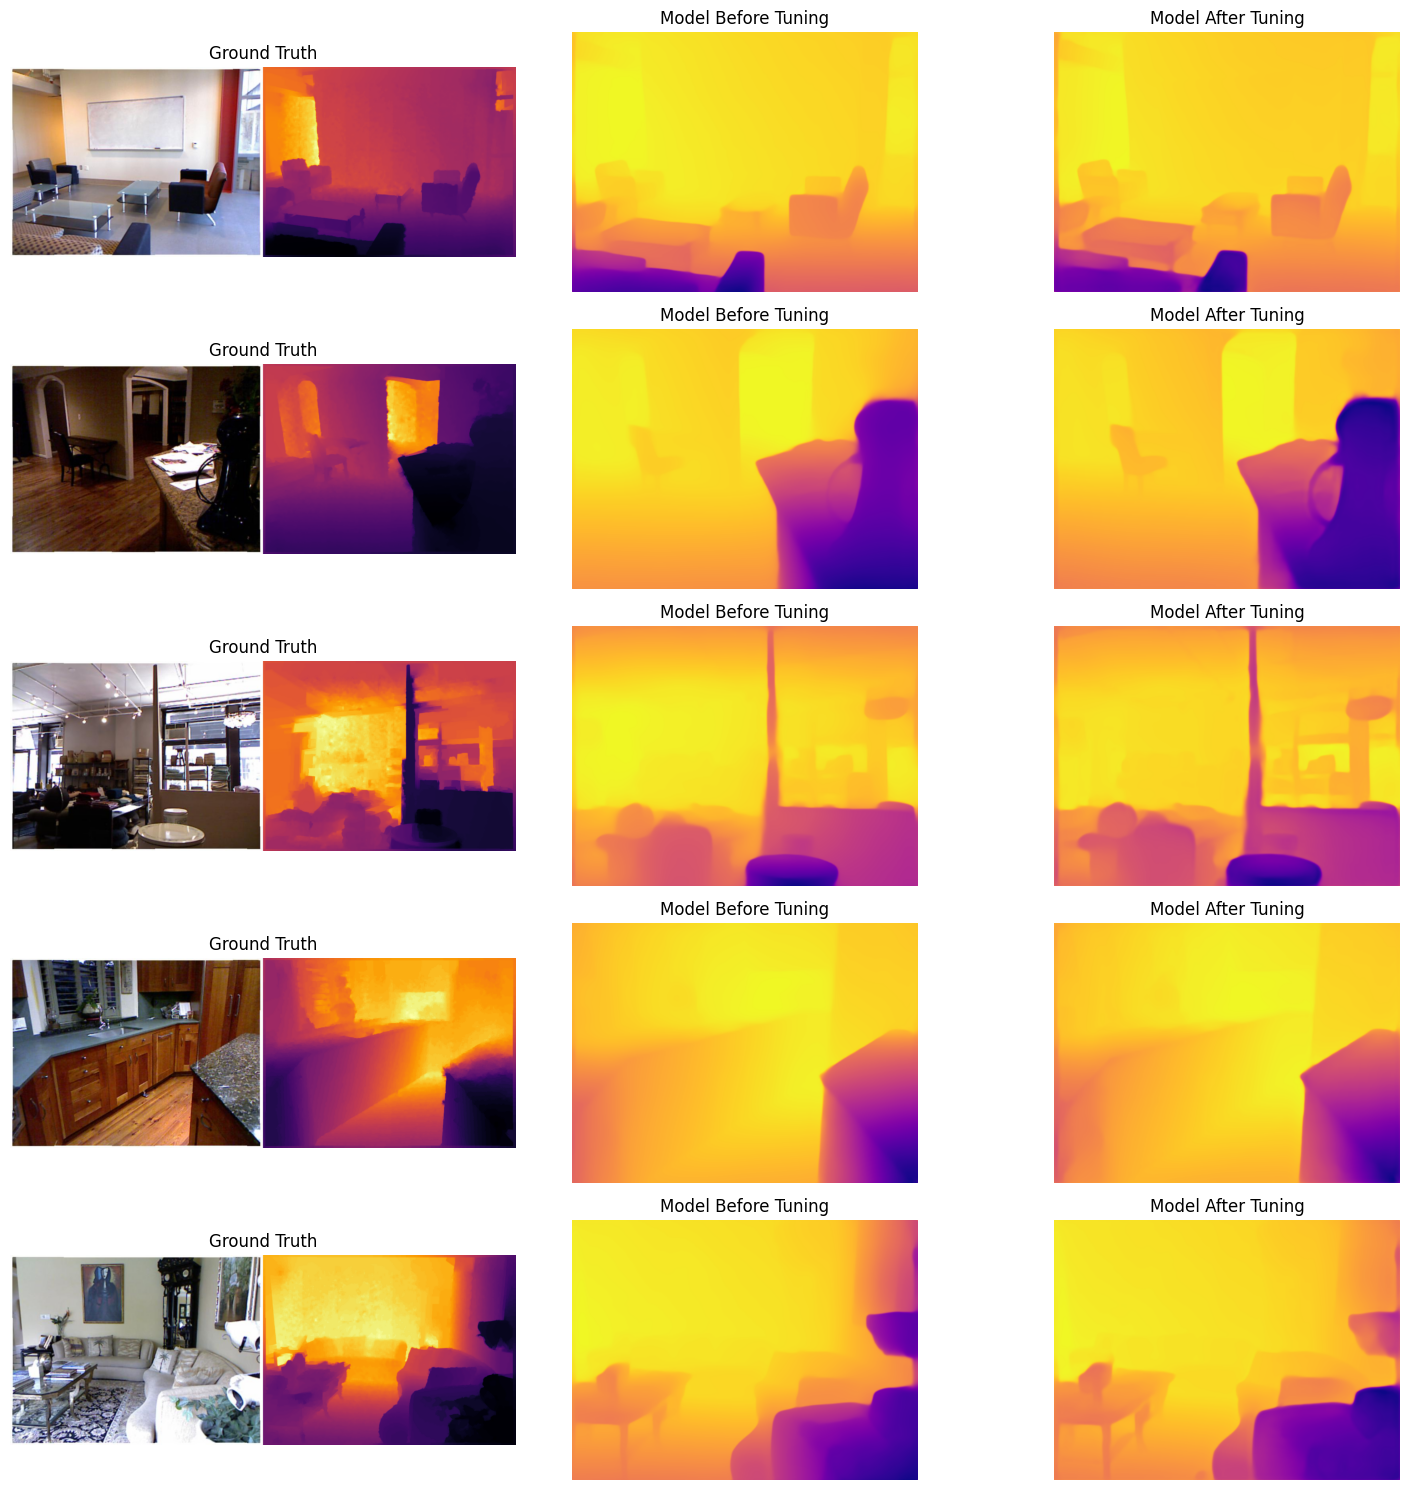

In [ ]:
import random
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import AutoModelForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_before = AutoModelForDepthEstimation.from_pretrained(
    "LiheYoung/depth-anything-small-hf"
).to(device)
model_after = AutoModelForDepthEstimation.from_pretrained(
    "./DepthAnything_Masked_Finetuned"
).to(device)
model_before.eval()
model_after.eval()

def preprocess_image(rgb_np, max_size=518):
    """
    Resize while keeping aspect ratio, matching real-time pipeline logic.
    """
    H, W = rgb_np.shape[:2]
    scale = max_size / max(H, W)
    new_W, new_H = int(W * scale), int(H * scale)
    img_resized = cv2.resize(rgb_np, (new_W, new_H), interpolation=cv2.INTER_LINEAR)
    tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float().div_(255.0)
    return tensor.to(device), (H, W), (new_H, new_W)

def infer_depth(model, rgb_np):
    x, (orig_H, orig_W), (new_H, new_W) = preprocess_image(rgb_np)
    with torch.no_grad():
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            pred = model(pixel_values=x).predicted_depth
    depth = pred.squeeze().detach().cpu().float().numpy()
    depth_resized = cv2.resize(depth, (orig_W, orig_H), interpolation=cv2.INTER_LINEAR)
    return depth_resized

def normalize_depth(depth, invert=True):
    """
    Normalize depth to [0, 255]. If invert=True, make near objects bright.
    """
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    if invert:
        depth_norm = 255 - depth_norm  # ✅ invert brightness
    return np.clip(depth_norm, 0, 255).astype(np.uint8)

# Random test samples
N = 5
indices = random.sample(range(len(test_ds)), N)

plt.figure(figsize=(15, N * 3))
for i, idx in enumerate(indices):
    rgb, depth_gt = test_ds[idx]
    rgb_np = (rgb.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    depth_gt_np = depth_gt.squeeze().cpu().numpy()

    # --- Model Before Tuning ---
    pred_b = infer_depth(model_before, rgb_np)
    pred_b_color = cv2.applyColorMap(normalize_depth(pred_b, invert=True), cv2.COLORMAP_PLASMA)

    # --- Model After Tuning ---
    pred_a = infer_depth(model_after, rgb_np)
    pred_a_color = cv2.applyColorMap(normalize_depth(pred_a, invert=True), cv2.COLORMAP_PLASMA)

    # --- Visualization ---
    plt.subplot(N, 3, i * 3 + 1)
    plt.imshow(merge_into_row(rgb_np, depth_gt_np).astype("uint8"))
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(N, 3, i * 3 + 2)
    plt.imshow(pred_b_color[..., ::-1])  # BGR→RGB
    plt.title("Model Before Tuning")
    plt.axis("off")

    plt.subplot(N, 3, i * 3 + 3)
    plt.imshow(pred_a_color[..., ::-1])
    plt.title("Model After Tuning")
    plt.axis("off")

plt.tight_layout()
plt.show()